In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_train = pd.read_csv('/kaggle/input/cis-ieee-unb-churn/df_train.csv')
df_test = pd.read_csv('/kaggle/input/cis-ieee-unb-churn/df_test.csv')

pd.set_option('display.max_columns', None)
df_train.head(10)

/kaggle/input/cis-ieee-unb-churn/df_train.csv
/kaggle/input/cis-ieee-unb-churn/df_test.csv


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,CLTV
0,7590-VHVEG,1,United States,California,Los Angeles,90001,"33.973616, -118.24902",33.973616,-118.249020,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,3964
1,3038-PQIUY,1,United States,California,Dulzura,91917,"32.622999, -116.687855",32.622999,-116.687855,Female,No,No,No,38,Yes,Yes,DSL,Yes,Yes,Yes,No,No,No,Month-to-month,Yes,Bank transfer (automatic),66.15,2522.4,No,4933
2,1468-DEFNC,1,United States,California,San Jose,95130,"37.277592, -121.986477",37.277592,-121.986477,Male,Yes,Yes,Yes,64,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),24.40,1548.65,No,4772
3,6437-UDQJM,1,United States,California,Los Angeles,90023,"34.017697, -118.200577",34.017697,-118.200577,Female,Yes,Yes,No,72,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),84.10,6129.65,No,4999
4,9490-DFPMD,1,United States,California,Tahoma,96142,"39.061227, -120.179546",39.061227,-120.179546,Female,Yes,No,No,42,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.65,3541.35,Yes,4871
5,1452-VOQCH,1,United States,California,Hinkley,92347,"34.983808, -117.239306",34.983808,-117.239306,Male,No,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.10,75.1,No,4120
6,2432-TFSMK,1,United States,California,Sebastopol,95472,"38.398815, -122.861923",38.398815,-122.861923,Male,No,No,No,18,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,One year,Yes,Credit card (automatic),89.60,1633,No,2269
7,3301-VKTGC,1,United States,California,Huron,93234,"36.217864, -120.080117",36.217864,-120.080117,Male,No,Yes,Yes,68,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,No,One year,Yes,Bank transfer (automatic),85.50,5696.6,No,4380
8,4818-DRBQT,1,United States,California,Farmersville,93223,"36.29878, -119.201028",36.298780,-119.201028,Male,No,Yes,No,29,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),80.15,2265.25,Yes,5189
9,3059-NGMXB,1,United States,California,San Jose,95124,"37.257063, -121.923037",37.257063,-121.923037,Male,No,Yes,Yes,14,Yes,Yes,DSL,Yes,Yes,No,No,No,Yes,Month-to-month,No,Mailed check,69.20,944.65,No,2871


# Análise exploratória

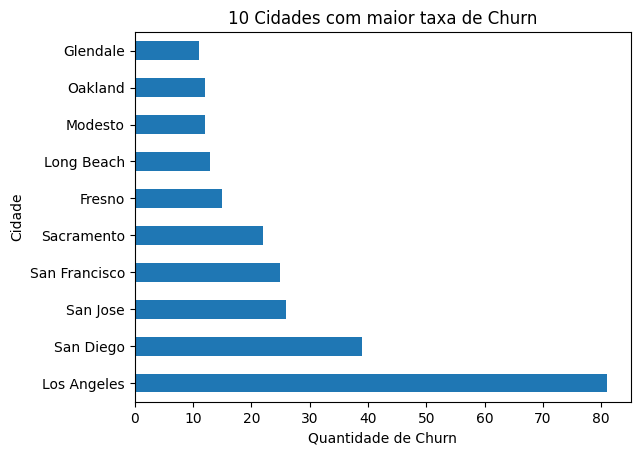

In [18]:
df_city = df_train.copy()
df_city['Churn Label'] = df_train['Churn Label'].map({'Yes': 1, 'No': 0})
df_city = df_city.groupby('City')['Churn Label'].sum()
df_city = df_city.nlargest(10)

df_city.plot(kind = 'barh')
plt.title('10 Cidades com maior taxa de Churn')
plt.xlabel('Quantidade de Churn')
plt.ylabel('Cidade')
plt.show

del df_city

O gráfico mostra uma taxa de churn significamente maior por parte da cidade de Los Angeles, com mais que o dobro da segunda do ranking.

In [19]:
df_cliente = df_train.copy()
df_cliente['Categoria_cliente'] = df_train['Tenure Months'].apply(lambda x: 'Recente' if x < 12 else 'Antigo')

df_cliente = df_cliente[df_cliente['Churn Label'] == 'Yes']
df_cliente = df_cliente.groupby('Churn Label')['Categoria_cliente'].value_counts()
print(df_cliente.to_string())

Churn Label  Categoria_cliente
Yes          Recente              839
             Antigo               738


Se considerarmos clientes antigos como sendo aqueles que permaneceram com a empresa por mais de 12 meses, temos uma maior taxa de churn entre os clientes mais recentes

Text(0.5, 1.0, 'Numero de assinantes por serviço')

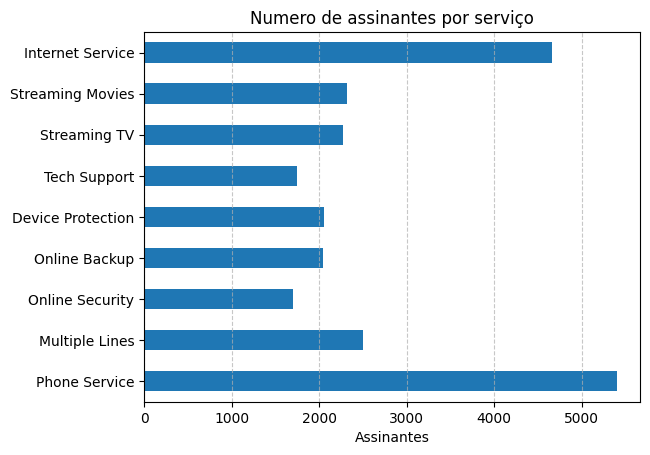

In [20]:
servicos = ['Internet Service', 'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']
df_servicos = df_train.copy()

servicos.remove('Internet Service')
df_servicos[servicos] = df_servicos[servicos].map(lambda x: 1 if x == 'Yes' else 0)

df_servicos['Internet Service'] = df_train['Internet Service'].map(lambda x: 1 if x != 'No' else 0)
servicos.append('Internet Service')

soma_servicos = df_servicos[servicos].sum()

soma_servicos.plot(kind='barh')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlabel('Assinantes')
plt.title('Numero de assinantes por serviço')

Os serviços menos utilizados são Online Security e Tech Support

# Pré Processamento

In [21]:
#Armazena CustumerID que será usada na hora de criar o csv para submissão
customerID_test = df_test['CustomerID']

#Concatena o dataframe de test e treino para fazer o preprocessamento.
#Antes do treinamento eles serão separados novamente
df_test['Churn Label'] = np.nan

df_train['is_train'] = 1
df_test['is_train'] = 0

df_full = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [22]:
irrelevant_columns = ['CustomerID',
                      'Zip Code',
                      'Lat Long',
                      'Country',
                      'Count',
                      'Total Charges']

df_full = df_full.drop(irrelevant_columns, axis=1) 

In [23]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['City',
                     'State',
                     'Gender',
                     'Senior Citizen',
                     'Partner',
                     'Dependents',
                     'Phone Service',
                     'Multiple Lines',
                     'Internet Service',
                     'Online Security',
                     'Online Backup',
                     'Device Protection',
                     'Tech Support',
                     'Streaming TV',
                     'Streaming Movies',
                     'Contract',
                     'Paperless Billing',
                     'Payment Method',
                     'Churn Label']

label_enconder = LabelEncoder()

for col in columns_to_encode:
    df_full[col] = label_enconder.fit_transform(df_full[col])

In [24]:
#Separa novamente entre dataset de treinamento e test
df_train_processed = df_full[df_full['is_train'] == 1].copy()
df_test_processed = df_full[df_full['is_train'] == 0].copy()

df_train_processed = df_train_processed.drop('is_train', axis=1)
df_test_processed = df_test_processed.drop(['is_train', 'Churn Label'], axis=1)

# Treinamento dos Modelos

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = df_train_processed.drop('Churn Label', axis=1)
y = df_train_processed['Churn Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
dt = DecisionTreeClassifier(random_state=12)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=12)

In [27]:
from sklearn.model_selection import cross_val_score, KFold

rf = RandomForestClassifier(n_estimators=500, random_state=8)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=8)

In [28]:
def calculate_metrics(model):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Acurácia: {accuracy:.2f}')
    print(f'Precisão: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')

In [29]:
print("Decision Tree")
calculate_metrics(dt)
print()
print("Random Forest")
calculate_metrics(rf)

Decision Tree
Acurácia: 0.73
Precisão: 0.47
Recall: 0.48
F1-score: 0.48

Random Forest
Acurácia: 0.81
Precisão: 0.70
Recall: 0.49
F1-score: 0.58


A validação cruzada é utilizada para que todos os dados sejam utilizados tanto para treino quanto para teste para que se obtenha métricas mais precias para a generalização de um modelo.
Tipos de validação cruzada:

K-fold:
    Os dados são divididos em K partes iguais. O
    modelo é treinado em K - 1 partes e testado ni
    parte restante, repetindo o processo K vezes. A
    performance final é a média das performances de
    cada rodada. É útil quando se tem uma quantida
    moderada de dados.    
    
Stratified:
    Funciona como o K-Fold, mas mantém a
    proporção das classes em cada parte, o que é
    importante quando as classes estão
    desbalanceadas.
    
Leave-One-Out:
    Cada exemplo é usado como teste uma vez,
    enquanto o restante é usado para treino. Isso é
    repetido para cada exemplo no conjunto de
    dados. É aplicado quando o conjunto de dados é
    muito pequeno.
    
        

In [30]:
kf = KFold(n_splits=10, shuffle=True, random_state=14)

scores_dt = cross_val_score(dt, X, y, cv=kf, scoring='f1')
scores_rf = cross_val_score(rf, X, y, cv=kf, scoring='f1')

print('Resultados da Validação Cruzada:')
print(f"F1 Score médio para Decision Tree: {scores_dt.mean():.2f}", )
print(f"F1 Score médio para Random Forest: {scores_rf.mean():.2f}", )

Resultados da Validação Cruzada:
F1 Score médio para Decision Tree: 0.51
F1 Score médio para Random Forest: 0.57


# Para submissão

In [31]:
df_test_processed['Churn Label'] = rf.predict(df_test_processed)
df_test_processed['Churn Label'].apply(lambda x: 'Yes' if x == 1 else 'No')
df_test_processed['Churn Label'].unique()

array([0, 1])

In [37]:
submission = pd.DataFrame({
    'CustomerID': customerID_test,
    'Churn Label': label_enconder.inverse_transform(df_test_processed['Churn Label'].astype(int))
})

submission.to_csv('submission.csv', index=False)
submission.head()

,CustomerID,Churn Label
0,2189-WWOEW,No
1,2446-ZKVAF,No
2,4986-MXSFP,No
3,5868-YWPDW,Yes
4,9412-GHEEC,No
